# IPL SEASON 18 (POWERPLAY ANALYSIS) - Bowling Analysis

# IPL 2025 Powerplay Bowling Analysis

## Objective
This notebook analyzes team-level bowling performance during the powerplay phase
of IPL 2025 matches, focusing on run control, wicket-taking, and pace vs spin effectiveness.

## Data Overview
- Dataset: IPL 2025 ball-by-ball data
- Matches analyzed: Match numbers ≤ 70
- Granularity: Delivery-level


Importing necessary python libraries

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional settings
plt.style.use("default")
pd.set_option("display.max_columns", None)


Importing and checking data

In [124]:
df = pd.read_csv("ipl2025.csv")

df.head()

,match_no,date,stage,venue,batting_team,bowling_team,innings,over,striker,bowler,bowler_type,runs_of_bat,extras,wide,legbyes,byes,noballs,wicket_type,player_dismissed,fielder
0,1,"Mar 22, 2025",League stage,"Eden Gardens, Kolkata",KKR,RCB,1,0.1,de Kock,Hazlewood,pace,0,0,0,0,0,0,NaN,NaN,NaN
1,1,"Mar 22, 2025",League stage,"Eden Gardens, Kolkata",KKR,RCB,1,0.2,de Kock,Hazlewood,pace,4,0,0,0,0,0,NaN,NaN,NaN
2,1,"Mar 22, 2025",League stage,"Eden Gardens, Kolkata",KKR,RCB,1,0.3,de Kock,Hazlewood,pace,0,0,0,0,0,0,NaN,NaN,NaN
3,1,"Mar 22, 2025",League stage,"Eden Gardens, Kolkata",KKR,RCB,1,0.4,de Kock,Hazlewood,pace,0,0,0,0,0,0,NaN,NaN,NaN
4,1,"Mar 22, 2025",League stage,"Eden Gardens, Kolkata",KKR,RCB,1,0.5,de Kock,Hazlewood,pace,0,0,0,0,0,0,caught,de Kock,Jitesh Sharma


In [125]:
df.columns


Index(['match_no', 'date', 'stage', 'venue', 'batting_team', 'bowling_team',
       'innings', 'over', 'striker', 'bowler', 'bowler_type', 'runs_of_bat',
       'extras', 'wide', 'legbyes', 'byes', 'noballs', 'wicket_type',
       'player_dismissed', 'fielder'],
      dtype='object')

## Runs conceded in powerplay and average runs conceded in powerplay

In [126]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Create total runs column
df["total_runs"] = df["runs_of_bat"] + df["extras"]

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Runs conceded per powerplay innings
pp_innings_runs = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        runs_conceded=("total_runs", "sum")
    )
    .reset_index()
)

# Team-level powerplay runs conceded
pp_team_runs = (
    pp_innings_runs
    .groupby("bowling_team")
    .agg(
        innings=("runs_conceded", "count"),
        total_runs_conceded=("runs_conceded", "sum"),
        avg_runs_conceded=("runs_conceded", "mean")
    )
    .reset_index()
)

# Round average to 2 decimal places
pp_team_runs["avg_runs_conceded"] = pp_team_runs["avg_runs_conceded"].round(2)

# Sort by average runs conceded (most to least)
pp_team_runs = pp_team_runs.sort_values("avg_runs_conceded", ascending=False)

# Reset index to remove old index numbers
pp_team_runs = pp_team_runs.reset_index(drop=True)
pp_team_runs.index = pp_team_runs.index + 1

pp_team_runs



,bowling_team,innings,total_runs_conceded,avg_runs_conceded
1,LSG,14,899,64.21
2,SRH,14,865,61.79
3,DC,13,759,58.38
4,CSK,14,804,57.43
5,GT,14,801,57.21
6,RR,14,784,56.00
7,KKR,13,725,55.77
8,MI,14,748,53.43
9,RCB,13,673,51.77
10,PBKS,14,724,51.71


### Bar Chart: Runs Conceded in Powerplay (by Team)

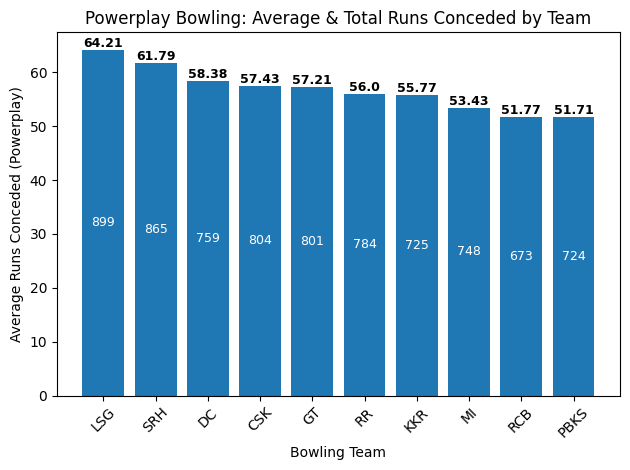

In [127]:
plt.figure()

bars = plt.bar(
    pp_team_runs["bowling_team"],
    pp_team_runs["avg_runs_conceded"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Runs Conceded (Powerplay)")
plt.title("Powerplay Bowling: Average & Total Runs Conceded by Team")

plt.xticks(rotation=45)

# Add labels (corrected)
for bar, avg, total in zip(
    bars,
    pp_team_runs["avg_runs_conceded"],
    pp_team_runs["total_runs_conceded"]
):
    height = bar.get_height()
    
    # Average runs on top of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total runs inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()



## Dot balls in powerplay

In [128]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Legal deliveries only
pp_df["is_legal_ball"] = (
    (pp_df["wide"] == 0) &
    (pp_df["noballs"] == 0)
)

# Dot balls (legal + no runs)
pp_df["is_dot_ball"] = (
    pp_df["is_legal_ball"] &
    (pp_df["runs_of_bat"] == 0) &
    (pp_df["extras"] == 0)
)

# Innings-level aggregation
pp_innings_dots = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        legal_balls=("is_legal_ball", "sum"),
        dot_balls=("is_dot_ball", "sum")
    )
    .reset_index()
)

# Team-level aggregation
pp_team_dotballs = (
    pp_innings_dots
    .groupby("bowling_team")
    .agg(
        innings=("dot_balls", "count"),
        total_balls=("legal_balls", "sum"),
        dot_balls=("dot_balls", "sum")
    )
    .reset_index()
)

# Metrics
pp_team_dotballs["dot_ball_pct"] = (
    (pp_team_dotballs["dot_balls"] / pp_team_dotballs["total_balls"]) * 100
).round(2)

pp_team_dotballs["avg_dot_balls"] = (
    pp_team_dotballs["dot_balls"] / pp_team_dotballs["innings"]
).round(2)

# Sort by most to least dot balls
pp_team_dotballs = pp_team_dotballs.sort_values("avg_dot_balls", ascending=False)

# Index starts from 1
pp_team_dotballs = pp_team_dotballs.reset_index(drop=True)
pp_team_dotballs.index = pp_team_dotballs.index + 1

pp_team_dotballs



,bowling_team,innings,total_balls,dot_balls,dot_ball_pct,avg_dot_balls
1,MI,14,504,224,44.44,16.00
2,RCB,13,456,203,44.52,15.62
3,GT,14,504,218,43.25,15.57
4,CSK,14,504,212,42.06,15.14
5,KKR,13,468,194,41.45,14.92
6,PBKS,14,462,208,45.02,14.86
7,RR,14,504,197,39.09,14.07
8,DC,13,468,182,38.89,14.00
9,SRH,14,504,185,36.71,13.21
10,LSG,14,504,181,35.91,12.93


### Bar Chart: Average Dot Balls in Powerplay

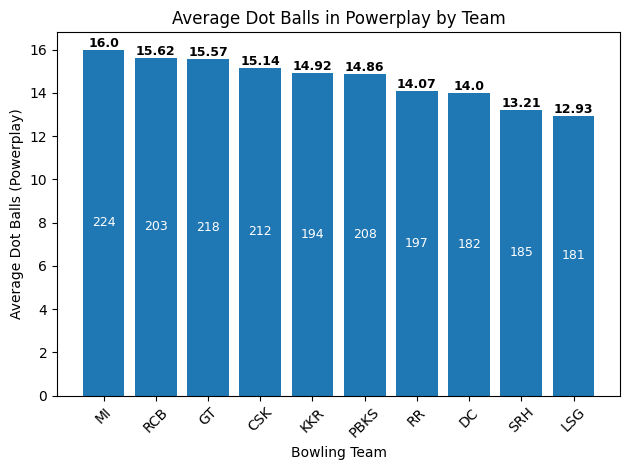

In [129]:
plt.figure()

bars = plt.bar(
    pp_team_dotballs["bowling_team"],
    pp_team_dotballs["avg_dot_balls"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Dot Balls (Powerplay)")
plt.title("Average Dot Balls in Powerplay by Team")

plt.xticks(rotation=45)

# Annotations (corrected)
for bar, avg_dots, total_dots in zip(
    bars,
    pp_team_dotballs["avg_dot_balls"],
    pp_team_dotballs["dot_balls"]
):
    height = bar.get_height()
    
    # Average dot balls on top of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg_dots}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total dot balls inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total_dots}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()


## Sixes conceded in powerplay with average sixes conceded in powerplay

In [130]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Identify sixes
pp_df["is_six"] = pp_df["runs_of_bat"] == 6

# Innings-level aggregation
pp_innings_sixes = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        sixes=("is_six", "sum")
    )
    .reset_index()
)

# Team-level aggregation
pp_team_sixes = (
    pp_innings_sixes
    .groupby("bowling_team")
    .agg(
        innings=("sixes", "count"),
        total_sixes=("sixes", "sum"),
        avg_sixes=("sixes", "mean")
    )
    .reset_index()
)

# Round average to 2 decimals
pp_team_sixes["avg_sixes"] = pp_team_sixes["avg_sixes"].round(2)

# Sort by average sixes conceded (most to least)
pp_team_sixes = pp_team_sixes.sort_values("avg_sixes", ascending=False)

# Index starts from 1
pp_team_sixes = pp_team_sixes.reset_index(drop=True)
pp_team_sixes.index = pp_team_sixes.index + 1

pp_team_sixes


,bowling_team,innings,total_sixes,avg_sixes
1,SRH,14,43,3.07
2,LSG,14,43,3.07
3,CSK,14,41,2.93
4,KKR,13,36,2.77
5,DC,13,35,2.69
6,GT,14,36,2.57
7,RCB,13,28,2.15
8,MI,14,29,2.07
9,PBKS,14,29,2.07
10,RR,14,23,1.64


### Bar Chart: Sixes Conceded in Powerplay

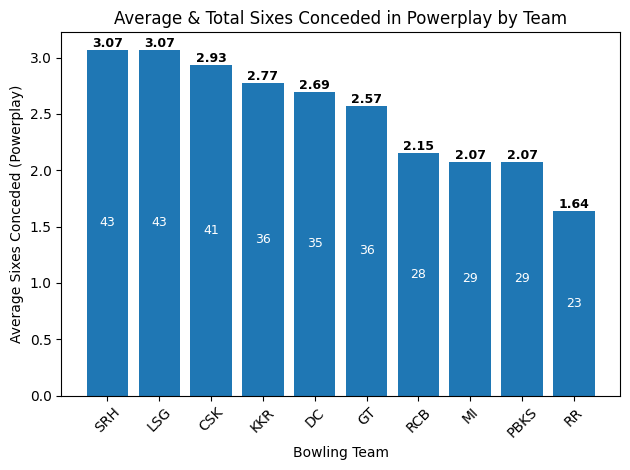

In [131]:
plt.figure()

bars = plt.bar(
    pp_team_sixes["bowling_team"],
    pp_team_sixes["avg_sixes"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Sixes Conceded (Powerplay)")
plt.title("Average & Total Sixes Conceded in Powerplay by Team")

plt.xticks(rotation=45)

# Corrected annotations
for bar, avg_six, total_six in zip(
    bars,
    pp_team_sixes["avg_sixes"],
    pp_team_sixes["total_sixes"]
):
    height = bar.get_height()
    
    # Average on top of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg_six}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total sixes inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total_six}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()


## innings without conceding a six in powerplay

In [132]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Identify sixes
pp_df["is_six"] = pp_df["runs_of_bat"] == 6

# Innings-level aggregation
pp_innings_sixes = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        sixes_conceded=("is_six", "sum")
    )
    .reset_index()
)

# Flag innings with zero sixes
pp_innings_sixes["no_six_innings"] = pp_innings_sixes["sixes_conceded"] == 0

# Team-level aggregation
pp_team_no_six = (
    pp_innings_sixes
    .groupby("bowling_team")
    .agg(
        innings_without_six=("no_six_innings", "sum")
    )
    .reset_index()
)

# Sort by most to least
pp_team_no_six = pp_team_no_six.sort_values(
    "innings_without_six", ascending=False
)

# Index starts from 1
pp_team_no_six = pp_team_no_six.reset_index(drop=True)
pp_team_no_six.index = pp_team_no_six.index + 1

pp_team_no_six


,bowling_team,innings_without_six
1,RR,4
2,KKR,2
3,RCB,2
4,SRH,2
5,PBKS,2
6,LSG,2
7,DC,1
8,CSK,1
9,MI,1
10,GT,1


### Chart: Powerplay Innings Without a Six (by Team)

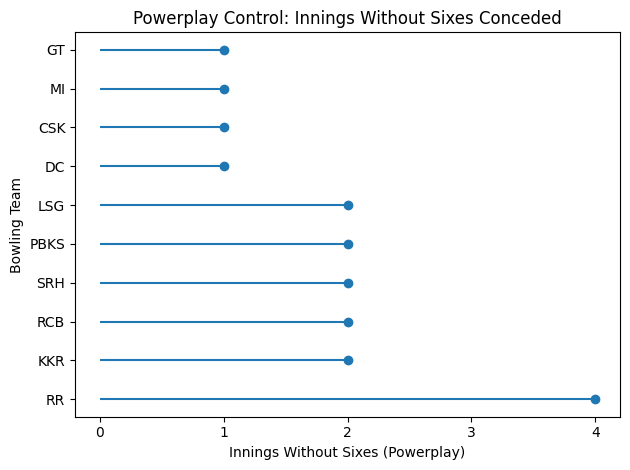

In [133]:
plt.figure()

plt.hlines(
    y=pp_team_no_six["bowling_team"],
    xmin=0,
    xmax=pp_team_no_six["innings_without_six"]
)

plt.plot(
    pp_team_no_six["innings_without_six"],
    pp_team_no_six["bowling_team"],
    "o"
)

plt.xlabel("Innings Without Sixes (Powerplay)")
plt.ylabel("Bowling Team")
plt.title("Powerplay Control: Innings Without Sixes Conceded")

# Force integer x-axis ticks
max_val = pp_team_no_six["innings_without_six"].max()
plt.xticks(range(0, max_val + 1))

plt.tight_layout()
plt.show()




##  Fours conceded in powerplay with average fours conceded in powerplay

In [134]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Identify fours
pp_df["is_four"] = pp_df["runs_of_bat"] == 4

# Innings-level aggregation
pp_innings_fours = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        fours_conceded=("is_four", "sum")
    )
    .reset_index()
)

# Team-level aggregation
pp_team_fours = (
    pp_innings_fours
    .groupby("bowling_team")
    .agg(
        innings=("fours_conceded", "count"),
        total_fours=("fours_conceded", "sum"),
        avg_fours=("fours_conceded", "mean")
    )
    .reset_index()
)

# Round average to 2 decimals
pp_team_fours["avg_fours"] = pp_team_fours["avg_fours"].round(2)

# Sort by average fours conceded (most to least)
pp_team_fours = pp_team_fours.sort_values("avg_fours", ascending=False)

# Index starts from 1
pp_team_fours = pp_team_fours.reset_index(drop=True)
pp_team_fours.index = pp_team_fours.index + 1

pp_team_fours


,bowling_team,innings,total_fours,avg_fours
1,LSG,14,103,7.36
2,RR,14,100,7.14
3,SRH,14,91,6.50
4,GT,14,91,6.50
5,PBKS,14,91,6.50
6,CSK,14,90,6.43
7,DC,13,79,6.08
8,RCB,13,79,6.08
9,MI,14,84,6.00
10,KKR,13,73,5.62


### Bar Chart: Fours Conceded in Powerplay

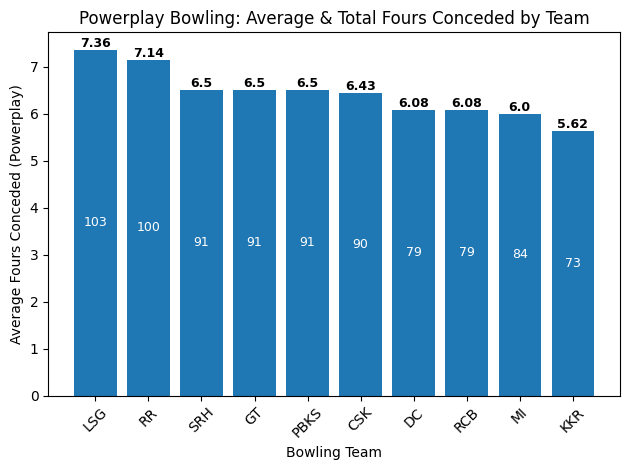

In [135]:
plt.figure()

bars = plt.bar(
    pp_team_fours["bowling_team"],
    pp_team_fours["avg_fours"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Fours Conceded (Powerplay)")
plt.title("Powerplay Bowling: Average & Total Fours Conceded by Team")

plt.xticks(rotation=45)

# Annotations (SOP-compliant)
for bar, avg_four, total_four in zip(
    bars,
    pp_team_fours["avg_fours"],
    pp_team_fours["total_fours"]
):
    height = bar.get_height()
    
    # Average on top of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg_four}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total_four}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()


## runs conceded in boundaries in powerplay(fours and sixes)

In [136]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Identify boundary balls
pp_df["is_boundary"] = pp_df["runs_of_bat"].isin([4, 6])

# Boundary runs
pp_df["boundary_runs"] = pp_df["runs_of_bat"].where(
    pp_df["is_boundary"], 0
)

# Innings-level aggregation
pp_innings_boundaries = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        boundaries=("is_boundary", "sum"),
        boundary_runs=("boundary_runs", "sum")
    )
    .reset_index()
)

# Team-level aggregation
pp_team_boundaries = (
    pp_innings_boundaries
    .groupby("bowling_team")
    .agg(
        innings=("boundaries", "count"),
        total_boundaries=("boundaries", "sum"),
        total_boundary_runs=("boundary_runs", "sum"),
        avg_boundary_runs=("boundary_runs", "mean")
    )
    .reset_index()
)

# Round average to 2 decimals
pp_team_boundaries["avg_boundary_runs"] = (
    pp_team_boundaries["avg_boundary_runs"].round(2)
)

# Sort by average boundary runs (most to least)
pp_team_boundaries = pp_team_boundaries.sort_values(
    "avg_boundary_runs", ascending=False
)

# Index starts from 1
pp_team_boundaries = pp_team_boundaries.reset_index(drop=True)
pp_team_boundaries.index = pp_team_boundaries.index + 1

pp_team_boundaries


,bowling_team,innings,total_boundaries,total_boundary_runs,avg_boundary_runs
1,LSG,14,146,670,47.86
2,SRH,14,134,622,44.43
3,CSK,14,131,606,43.29
4,GT,14,127,580,41.43
5,DC,13,114,526,40.46
6,KKR,13,109,508,39.08
7,RR,14,123,538,38.43
8,PBKS,14,120,538,38.43
9,RCB,13,107,484,37.23
10,MI,14,113,510,36.43


### Bar Chart: Boundary Runs Conceded in Powerplay

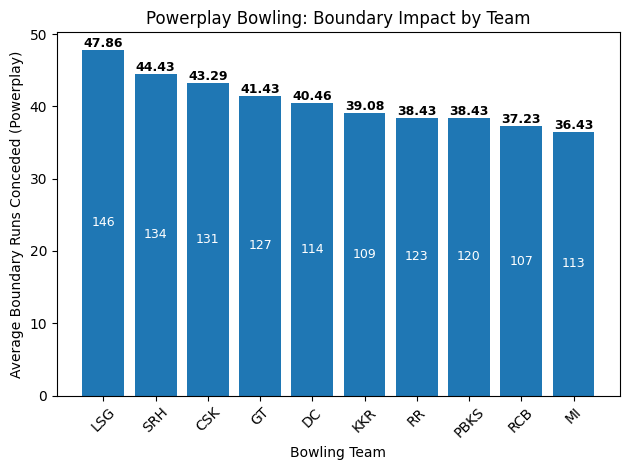

In [137]:
plt.figure()

bars = plt.bar(
    pp_team_boundaries["bowling_team"],
    pp_team_boundaries["avg_boundary_runs"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Boundary Runs Conceded (Powerplay)")
plt.title("Powerplay Bowling: Boundary Impact by Team")

plt.xticks(rotation=45)

# Annotations (SOP-compliant)
for bar, avg_runs, total_boundaries in zip(
    bars,
    pp_team_boundaries["avg_boundary_runs"],
    pp_team_boundaries["total_boundaries"]
):
    height = bar.get_height()
    
    # Average boundary runs on top
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg_runs}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total boundaries inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total_boundaries}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Dumbbell Chart (Average Fours vs Sixes)

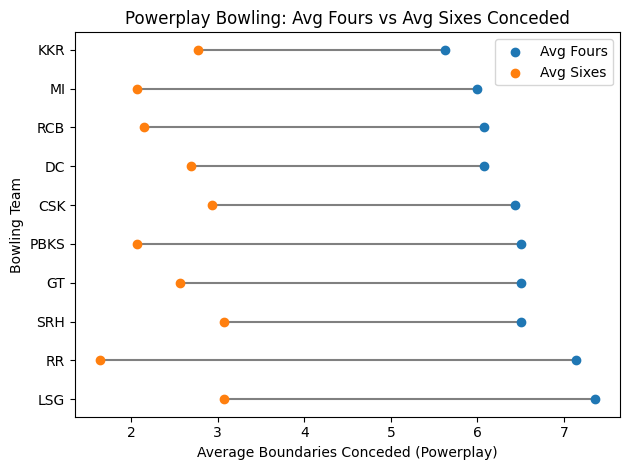

In [138]:
plt.figure()

# Merge averages
compare_df = (
    pp_team_fours[["bowling_team", "avg_fours"]]
    .merge(
        pp_team_sixes[["bowling_team", "avg_sixes"]],
        on="bowling_team"
    )
)

# Plot lines
plt.hlines(
    y=compare_df["bowling_team"],
    xmin=compare_df["avg_fours"],
    xmax=compare_df["avg_sixes"],
    color="gray"
)

# Plot points
plt.scatter(
    compare_df["avg_fours"],
    compare_df["bowling_team"],
    label="Avg Fours",
    zorder=3
)

plt.scatter(
    compare_df["avg_sixes"],
    compare_df["bowling_team"],
    label="Avg Sixes",
    zorder=3
)

plt.xlabel("Average Boundaries Conceded (Powerplay)")
plt.ylabel("Bowling Team")
plt.title("Powerplay Bowling: Avg Fours vs Avg Sixes Conceded")

plt.legend()
plt.tight_layout()
plt.show()


## runs conceded in extras in powerplay

In [139]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Innings-level aggregation
pp_innings_extras = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .agg(
        extras_runs=("extras", "sum")
    )
    .reset_index()
)

# Team-level aggregation
pp_team_extras = (
    pp_innings_extras
    .groupby("bowling_team")
    .agg(
        innings=("extras_runs", "count"),
        total_extras_runs=("extras_runs", "sum"),
        avg_extras_runs=("extras_runs", "mean")
    )
    .reset_index()
)

# Round average to 2 decimals
pp_team_extras["avg_extras_runs"] = (
    pp_team_extras["avg_extras_runs"].round(2)
)

# Sort by average extras runs (most to least)
pp_team_extras = pp_team_extras.sort_values(
    "avg_extras_runs", ascending=False
)

# Index starts from 1
pp_team_extras = pp_team_extras.reset_index(drop=True)
pp_team_extras.index = pp_team_extras.index + 1

pp_team_extras


,bowling_team,innings,total_extras_runs,avg_extras_runs
1,GT,14,59,4.21
2,DC,13,45,3.46
3,SRH,14,47,3.36
4,LSG,14,41,2.93
5,RR,14,40,2.86
6,MI,14,38,2.71
7,KKR,13,33,2.54
8,PBKS,14,32,2.29
9,RCB,13,23,1.77
10,CSK,14,23,1.64


### Bar Chart: Extras Runs Conceded in Powerplay

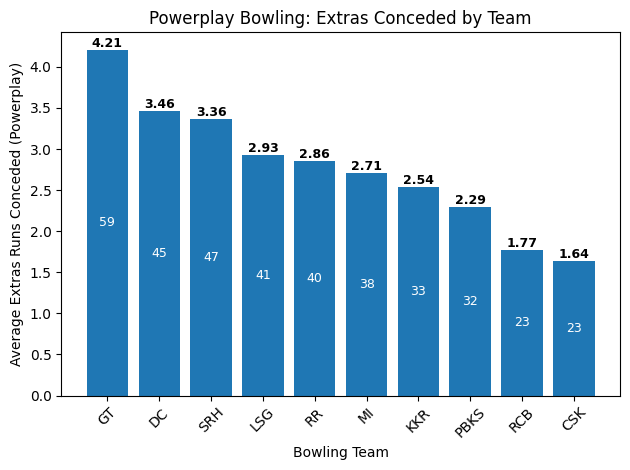

In [140]:
plt.figure()

bars = plt.bar(
    pp_team_extras["bowling_team"],
    pp_team_extras["avg_extras_runs"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Extras Runs Conceded (Powerplay)")
plt.title("Powerplay Bowling: Extras Conceded by Team")

plt.xticks(rotation=45)

# Annotations (SOP-compliant)
for bar, avg_extras, total_extras in zip(
    bars,
    pp_team_extras["avg_extras_runs"],
    pp_team_extras["total_extras_runs"]
):
    height = bar.get_height()
    
    # Average extras on top
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg_extras}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total extras inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total_extras}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()


## economy of teams,pacers,spinners

In [141]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Total runs
df["total_runs"] = df["runs_of_bat"] + df["extras"]

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Legal deliveries
pp_df["is_legal_ball"] = (
    (pp_df["wide"] == 0) &
    (pp_df["noballs"] == 0)
)

# ---------- INNINGS COUNT ----------
innings_df = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .size()
    .reset_index(name="balls")
)

team_innings = (
    innings_df
    .groupby("bowling_team")
    .size()
    .reset_index(name="innings")
)

# ---------- PACERS ----------
pp_pace = pp_df[pp_df["bowler_type"] == "pace"]

pace_team = (
    pp_pace
    .groupby("bowling_team")
    .agg(
        pace_runs=("total_runs", "sum"),
        pace_balls=("is_legal_ball", "sum")
    )
    .reset_index()
)

pace_team["pace_overs"] = pace_team["pace_balls"] / 6
pace_team["pace_economy"] = (pace_team["pace_runs"] / pace_team["pace_overs"]).round(2)

pace_team = pace_team[["bowling_team", "pace_economy"]]

# ---------- SPINNERS ----------
pp_spin = pp_df[pp_df["bowler_type"] == "spin"]

spin_team = (
    pp_spin
    .groupby("bowling_team")
    .agg(
        spin_runs=("total_runs", "sum"),
        spin_balls=("is_legal_ball", "sum")
    )
    .reset_index()
)

spin_team["spin_overs"] = spin_team["spin_balls"] / 6
spin_team["spin_economy"] = (spin_team["spin_runs"] / spin_team["spin_overs"]).round(2)

spin_team = spin_team[["bowling_team", "spin_economy"]]

# ---------- OVERALL TEAM ----------
team_overall = (
    pp_df
    .groupby("bowling_team")
    .agg(
        runs=("total_runs", "sum"),
        balls=("is_legal_ball", "sum")
    )
    .reset_index()
)

team_overall["overs"] = team_overall["balls"] / 6
team_overall["overall_economy"] = (team_overall["runs"] / team_overall["overs"]).round(2)

team_overall = team_overall[["bowling_team", "overall_economy"]]

# ---------- COMBINE ----------
pp_team_economy = (
    team_overall
    .merge(team_innings, on="bowling_team", how="left")
    .merge(pace_team, on="bowling_team", how="left")
    .merge(spin_team, on="bowling_team", how="left")
)

# Sort by highest to lowest overall economy
pp_team_economy = pp_team_economy.sort_values(
    "overall_economy", ascending=False
)

# Index starts from 1
pp_team_economy = pp_team_economy.reset_index(drop=True)
pp_team_economy.index = pp_team_economy.index + 1

pp_team_economy


,bowling_team,overall_economy,innings,pace_economy,spin_economy
1,LSG,10.70,14,11.28,9.17
2,SRH,10.30,14,10.28,10.50
3,DC,9.73,13,10.25,8.41
4,CSK,9.57,14,9.27,11.07
5,GT,9.54,14,9.51,10.00
6,PBKS,9.40,14,9.30,10.10
7,RR,9.33,14,9.29,9.50
8,KKR,9.29,13,10.12,6.90
9,MI,8.90,14,8.71,11.00
10,RCB,8.86,13,8.82,9.40


### Bar Chart: Overall Economy in Powerplay (by Team)

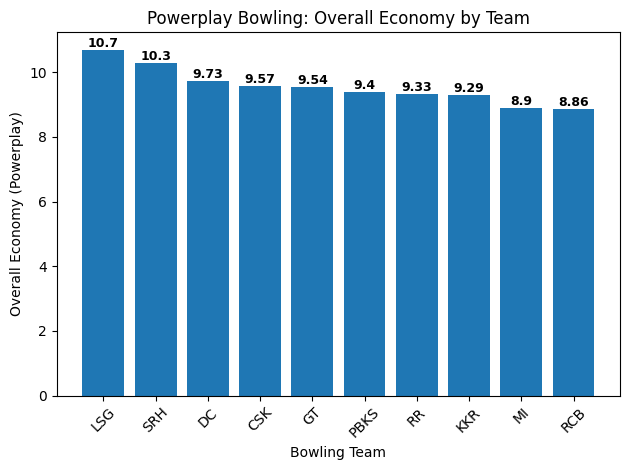

In [142]:
plt.figure()

bars = plt.bar(
    pp_team_economy["bowling_team"],
    pp_team_economy["overall_economy"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Overall Economy (Powerplay)")
plt.title("Powerplay Bowling: Overall Economy by Team")

plt.xticks(rotation=45)

# Value labels on top
for bar, econ in zip(bars, pp_team_economy["overall_economy"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{econ}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


### Dumbbell Chart — Pace vs Spin Economy

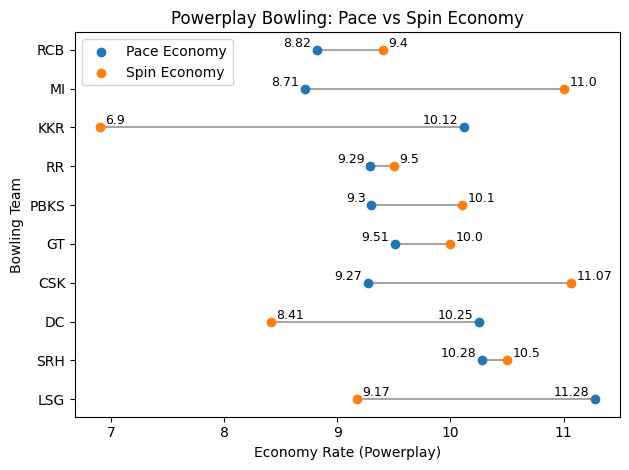

In [143]:
plt.figure()

# Draw dumbbell lines
plt.hlines(
    y=pp_team_economy["bowling_team"],
    xmin=pp_team_economy["pace_economy"],
    xmax=pp_team_economy["spin_economy"],
    color="gray",
    alpha=0.7
)

# Pace and spin dots
plt.scatter(
    pp_team_economy["pace_economy"],
    pp_team_economy["bowling_team"],
    zorder=3,
    label="Pace Economy"
)

plt.scatter(
    pp_team_economy["spin_economy"],
    pp_team_economy["bowling_team"],
    zorder=3,
    label="Spin Economy"
)

plt.xlabel("Economy Rate (Powerplay)")
plt.ylabel("Bowling Team")
plt.title("Powerplay Bowling: Pace vs Spin Economy")

# Add values above the dumbbell, offset sideways
x_offset = 0.05  # horizontal spacing for labels

for _, row in pp_team_economy.iterrows():
    
    # Pace economy value (top-left)
    plt.text(
        row["pace_economy"] - x_offset,
        row["bowling_team"],
        f'{row["pace_economy"]}',
        ha="right",
        va="bottom",
        fontsize=9
    )
    
    # Spin economy value (top-right)
    plt.text(
        row["spin_economy"] + x_offset,
        row["bowling_team"],
        f'{row["spin_economy"]}',
        ha="left",
        va="bottom",
        fontsize=9
    )

plt.legend()
plt.tight_layout()
plt.show()




## Powerplay Wickets by Pacers, Spinners & Overall (Team-wise)

In [144]:
# Load data
df = pd.read_csv("ipl2025.csv")

# Filter matches
df = df[df["match_no"] <= 70].copy()

# Define powerplay end over
df["pp_end_over"] = 5.6
df.loc[df["match_no"] == 34, "pp_end_over"] = 3.6

# Filter powerplay deliveries
pp_df = df[
    (df["over"] >= 0.1) &
    (df["over"] <= df["pp_end_over"])
].copy()

# Wicket definitions (final, verified)
bowler_wickets = [
    "caught", "bowled", "stumped", "lbw", "hit wicket"
]

team_wickets = [
    "caught", "bowled", "stumped", "lbw",
    "runout", "hit wicket", "retired out"
]

# Flags
pp_df["is_bowler_wicket"] = pp_df["wicket_type"].isin(bowler_wickets)
pp_df["is_team_wicket"] = pp_df["wicket_type"].isin(team_wickets)

# ---------- INNINGS COUNT ----------
innings_df = (
    pp_df
    .groupby(["match_no", "innings", "bowling_team"])
    .size()
    .reset_index(name="balls")
)

team_innings = (
    innings_df
    .groupby("bowling_team")
    .size()
    .reset_index(name="innings")
)

# ---------- PACERS ----------
pace_wickets = (
    pp_df[
        (pp_df["bowler_type"] == "pace") &
        (pp_df["is_bowler_wicket"])
    ]
    .groupby("bowling_team")
    .size()
    .reset_index(name="pace_wickets")
)

# ---------- SPINNERS ----------
spin_wickets = (
    pp_df[
        (pp_df["bowler_type"] == "spin") &
        (pp_df["is_bowler_wicket"])
    ]
    .groupby("bowling_team")
    .size()
    .reset_index(name="spin_wickets")
)

# ---------- TOTAL TEAM WICKETS ----------
total_team_wickets = (
    pp_df[
        pp_df["is_team_wicket"]
    ]
    .groupby("bowling_team")
    .size()
    .reset_index(name="total_wickets")
)

# ---------- COMBINE ----------
pp_team_wickets = (
    total_team_wickets
    .merge(team_innings, on="bowling_team", how="left")
    .merge(pace_wickets, on="bowling_team", how="left")
    .merge(spin_wickets, on="bowling_team", how="left")
)

pp_team_wickets[["pace_wickets", "spin_wickets"]] = (
    pp_team_wickets[["pace_wickets", "spin_wickets"]]
    .fillna(0)
    .astype(int)
)

# ---------- AVERAGE WICKETS ----------
pp_team_wickets["avg_wickets"] = (
    pp_team_wickets["total_wickets"] / pp_team_wickets["innings"]
).round(2)

# Sort by total wickets (most to least)
pp_team_wickets = pp_team_wickets.sort_values(
    "avg_wickets", ascending=False
)

# Index starts from 1
pp_team_wickets = pp_team_wickets.reset_index(drop=True)
pp_team_wickets.index = pp_team_wickets.index + 1

pp_team_wickets


,bowling_team,total_wickets,innings,pace_wickets,spin_wickets,avg_wickets
1,RCB,22,13,20,2,1.69
2,MI,23,14,22,1,1.64
3,KKR,20,13,14,6,1.54
4,DC,20,13,10,6,1.54
5,CSK,20,14,18,2,1.43
6,SRH,20,14,20,0,1.43
7,PBKS,19,14,15,4,1.36
8,GT,19,14,18,1,1.36
9,LSG,18,14,14,4,1.29
10,RR,17,14,15,1,1.21


### Bar Chart: Powerplay Wickets (Average & Total)

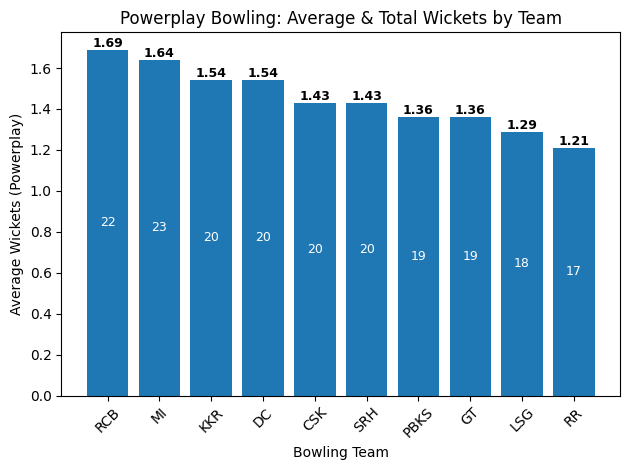

In [145]:
plt.figure()

bars = plt.bar(
    pp_team_wickets["bowling_team"],
    pp_team_wickets["avg_wickets"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Average Wickets (Powerplay)")
plt.title("Powerplay Bowling: Average & Total Wickets by Team")

plt.xticks(rotation=45)

# Annotations (SOP-compliant)
for bar, avg_wkts, total_wkts in zip(
    bars,
    pp_team_wickets["avg_wickets"],
    pp_team_wickets["total_wickets"]
):
    height = bar.get_height()
    
    # Average wickets on top of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{avg_wkts}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
    
    # Total wickets inside the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{total_wkts}",
        ha="center",
        va="center",
        color="white",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Bar Chart: Powerplay Wickets by Pacers

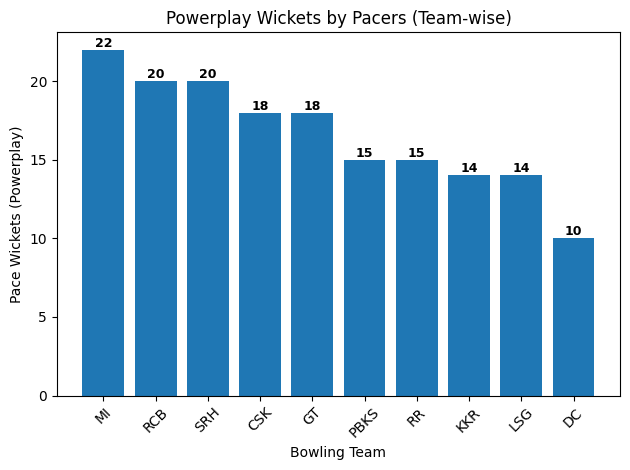

In [146]:
# Sort by pace wickets (high to low)
pace_df = pp_team_wickets.sort_values(
    "pace_wickets", ascending=False
)

plt.figure()

bars = plt.bar(
    pace_df["bowling_team"],
    pace_df["pace_wickets"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Pace Wickets (Powerplay)")
plt.title("Powerplay Wickets by Pacers (Team-wise)")

plt.xticks(rotation=45)

# Labels on top
for bar, val in zip(bars, pace_df["pace_wickets"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{val}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


### Bar Chart: Powerplay Wickets by Spinners

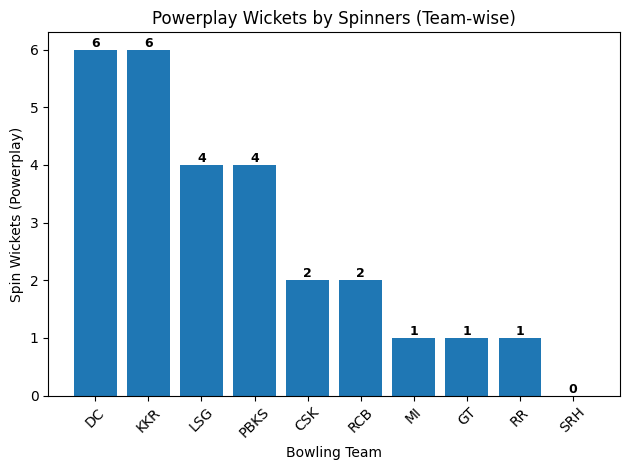

In [147]:
# Sort by spin wickets (high to low)
spin_df = pp_team_wickets.sort_values(
    "spin_wickets", ascending=False
)

plt.figure()

bars = plt.bar(
    spin_df["bowling_team"],
    spin_df["spin_wickets"]
)

plt.xlabel("Bowling Team")
plt.ylabel("Spin Wickets (Powerplay)")
plt.title("Powerplay Wickets by Spinners (Team-wise)")

plt.xticks(rotation=45)

# Labels on top
for bar, val in zip(bars, spin_df["spin_wickets"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{val}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()
